In [5]:
!pip -q install rectools
!pip -q install shap

In [8]:
import os
import warnings

warnings.simplefilter("ignore")

import gc
import json
import pickle
from typing import Any, Dict, Tuple
from zipfile import ZipFile

import numpy as np
import pandas as pd
import requests
import shap
from lightfm import LightFM
from lightgbm import LGBMClassifier, LGBMRanker
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import MAP, NDCG, MeanInvUserFreq, Precision, Recall, calc_metrics
from rectools.models import LightFMWrapperModel, PopularModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [9]:
users = pd.read_csv("data_original/users.csv")
items = pd.read_csv("data_original/items.csv")
interactions = pd.read_csv("data_original/interactions.csv")

In [10]:
interactions.count()

user_id          5476251
item_id          5476251
last_watch_dt    5476251
total_dur        5476251
watched_pct      5475423
dtype: int64

In [11]:
interactions.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)
interactions["datetime"] = interactions["datetime"].astype(np.datetime64)

interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.0,
    "total_dur": 0,
}
interactions.fillna(interactions_default_values, inplace=True)

interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [12]:
interactions.describe(datetime_is_numeric=True)

,user_id,item_id,datetime,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


In [13]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


users_cat_cols = [
    # 'user_id',
    "age",
    "income",
    "sex",
    "kids_flg",
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding["income"], users["income"].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [14]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    "content_type",
    "for_kids",
    "studios",
]
items_text_cols = [
    "title",
    "title_orig",
    "genres",
    "countries",
    "directors",
    "actors",
    "description",
    "keywords",
]
items_num_cols = [
    "release_year",
    "age_rating",
]
default_values_items = {
    "release_year": items["release_year"].median(),
    "age_rating": items["age_rating"].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding["studios"]

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [16]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]


train_size = 0.7
val_size = 0.15
test_size = 0.15


train_val_users, test_users = train_test_split(
    ranker_data["user_id"].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users,
    random_state=42,
    test_size=val_size / (train_size + val_size),  # 15% от общего размера
)

In [17]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

# Добавляем кандидатов из light_fm и популярного

In [19]:
lfm_candidates = pd.read_csv("lfm_preds.csv")

In [20]:
dataset = Dataset.construct(base_models_data)
popular_model = PopularModel()
popular_model.fit(dataset)

In [21]:
n_items = items[Columns.Item].nunique()
pop_candidates = popular_model.recommend(
    dataset.user_id_map.external_ids[:1], dataset, n_items, True
)
pop_candidates.rename({"rank": "pop_rank", "score": "pop_score"}, axis=1, inplace=True)
pop_candidates.drop(Columns.User, axis=1, inplace=True)
pop_candidates.head()

,item_id,pop_score,pop_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


In [22]:
candidates = lfm_candidates.merge(pop_candidates, how="left", on=[Columns.Item])
candidates.head()

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,7571,3.588528,1,20407.0,15.0
1,176549,13865,3.561206,2,93403.0,3.0
2,176549,3734,3.449158,3,50004.0,6.0
3,176549,10440,3.278818,4,141889.0,1.0
4,176549,12173,3.218931,5,10182.0,28.0


In [ ]:
del lfm_candidates
gc.collect()
del pop_candidates
gc.collect()

# Метрики

In [24]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        "ndcg@10": NDCG(k=10),
        "map@10": MAP(k=10),
        "Precision@10": Precision(k=10),
        "recall@10": Recall(k=10),
        "novelty@10": MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df.rename(columns={rank_col: Columns.Rank})[
                [Columns.User, Columns.Item, Columns.Rank]
            ][candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                ranker_data[Columns.User].isin(test_users)
            ]
        ),
        prev_interactions=(
            base_models_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                base_models_data[Columns.User].isin(test_users)
            ]
        ),
        catalog=items["item_id"].unique(),
    )

In [25]:
models_metrics: Dict[str, Dict[str, float]] = dict()

In [26]:
models_metrics["lfm"] = calc_metrics_(candidates, "lfm_rank")
models_metrics["lfm"]

{'Precision@10': 0.0265359998772121,
 'recall@10': 0.08592262812716776,
 'ndcg@10': 0.03367425306526139,
 'map@10': 0.04401265916961429,
 'novelty@10': 3.303739675429074}

In [27]:
models_metrics["pop"] = calc_metrics_(candidates, "pop_rank")
models_metrics["pop"]

{'Precision@10': 0.01946495172900711,
 'recall@10': 0.06551080425227873,
 'ndcg@10': 0.02408150980932602,
 'map@10': 0.03132230695945209,
 'novelty@10': 3.123651145809337}

# Добавляем фичей
а

In [28]:
base_models_data["user_hist"] = base_models_data.groupby("user_id")["item_id"].transform("count")

base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform("count")

base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("mean")

base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")["user_hist"].transform(
    "mean"
)

base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")["item_pop"].transform(
    "first"
)
# NEW: Общее время просмотра для юзера
base_models_data["time_watched"] = base_models_data["total_dur"] * base_models_data["weight"] / 100
base_models_data["user_watch_time"] = base_models_data.groupby("user_id")["time_watched"].transform(
    "sum"
)
base_models_data.drop("time_watched", axis=1, inplace=True)

base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop,user_watch_time
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208,7.67
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208,7.67
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208,7.67


In [29]:
items = pd.merge(
    left=items,
    right=(base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(
        base_models_data[
            ["user_id", "user_hist", "user_avg_pop", "user_last_pop", "user_watch_time"]
        ].drop_duplicates()
    ),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,user_watch_time
0,973171,1,4,1,1,5.0,19550.800000,93403.0,171398.16
1,962099,0,2,1,0,13.0,1329.307692,260.0,58671.26
2,1047345,3,3,0,0,NaN,NaN,NaN,NaN


In [30]:
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
    "user_watch_time": 0,
}

In [31]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="right",
        on=["user_id", "item_id"],
    )
    # Проставляем дефолтные значения интеракций
    lfm_min_score: float = df["lfm_score"].min() - 0.01
    lfm_max_rank: int = df["lfm_rank"].max() + 1  # 51
    pop_min_score: float = df["pop_score"].min() - 0.01
    pop_max_rank: int = df["pop_rank"].max() + 1  # 51

    default_values = {
        "lfm_score": lfm_min_score,
        "lfm_rank": lfm_max_rank,
        "pop_score": pop_min_score,
        "pop_rank": pop_max_rank,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank
5866535,3,101,2021-07-01,0.0,0.0,1.764648,36,26.99,5295.0
5866508,3,142,2021-08-13,5892.0,100.0,2.385213,9,35862.00,8.0
5866524,3,849,2021-07-01,0.0,0.0,1.962757,25,13304.00,26.0


In [32]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])


    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)


    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df



ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,user_watch_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,101,2021-07-01,0.0,0.0,1.764648,36,26.99,5295.0,-1,...,11957.864865,2858.0,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673
1,3,142,2021-08-13,5892.0,100.0,2.385213,9,35862.00,8.0,-1,...,11957.864865,2858.0,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,849,2021-07-01,0.0,0.0,1.962757,25,13304.00,26.0,-1,...,11957.864865,2858.0,0.0,0,2018.0,-1,18.0,-1,13304.0,16.444678


In [33]:
del candidates
gc.collect()

0

# Pointwise

In [35]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df["target"] = df[Columns.Weight] > 50  # 'watched_pct'
    df["target"] = df["target"].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_last_pop,user_watch_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,101,2021-07-01,0.0,0.0,1.764648,36,26.99,5295.0,-1,...,2858.0,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0
1,3,142,2021-08-13,5892.0,100.0,2.385213,9,35862.00,8.0,-1,...,2858.0,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1
2,3,849,2021-07-01,0.0,0.0,1.962757,25,13304.00,26.0,-1,...,2858.0,0.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0


In [36]:
def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    groups_df = (
        df[["user_id", "item_id"]]
        .groupby(by=["user_id"])
        .count()
        .rename(columns={"item_id": "group_size"})
    )
    df = pd.merge(df, groups_df, how="left", on=["user_id"])
    df = df[df["group_size"] >= 50]

    df.drop(columns=["group_size"], inplace=True)
    return df


def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["lfm_rank"] <= 50]


ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [37]:
cols = [
    "lfm_score",
    "lfm_rank",
    "pop_score",
    "pop_rank",
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "user_watch_time",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]

cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]

In [38]:
early_stopping_rounds = 32

params = {
    "objective": "binary",
    "n_estimators": 10000, 
    "max_depth": 4, 
    "num_leaves": 10, 
    "min_child_samples": 100, 
    "learning_rate": 0.25,
    "reg_lambda": 1, 
    "colsample_bytree": 0.9,  
    "early_stopping_rounds": early_stopping_rounds, 
    "verbose": early_stopping_rounds // 8, 
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],
    "eval_set": [(ranker_val[cols], ranker_val["target"])],
    "eval_metric": "logloss",
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] Number of positive: 64894, number of negative: 6695356
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.924358
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.223499
[LightGBM] [Debug] init for col-wise cost 0.058264 seconds, init for row-wise cost 0.126903 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 6760250, number of used features: 19
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[L

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [39]:
pointwise_model.best_score_["valid_0"]["binary_logloss"]

0.04587627239710803

In [40]:
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap_values.values = shap_values.values[:, :, 1]
shap_values.base_values = shap_values.base_values[:, 1]

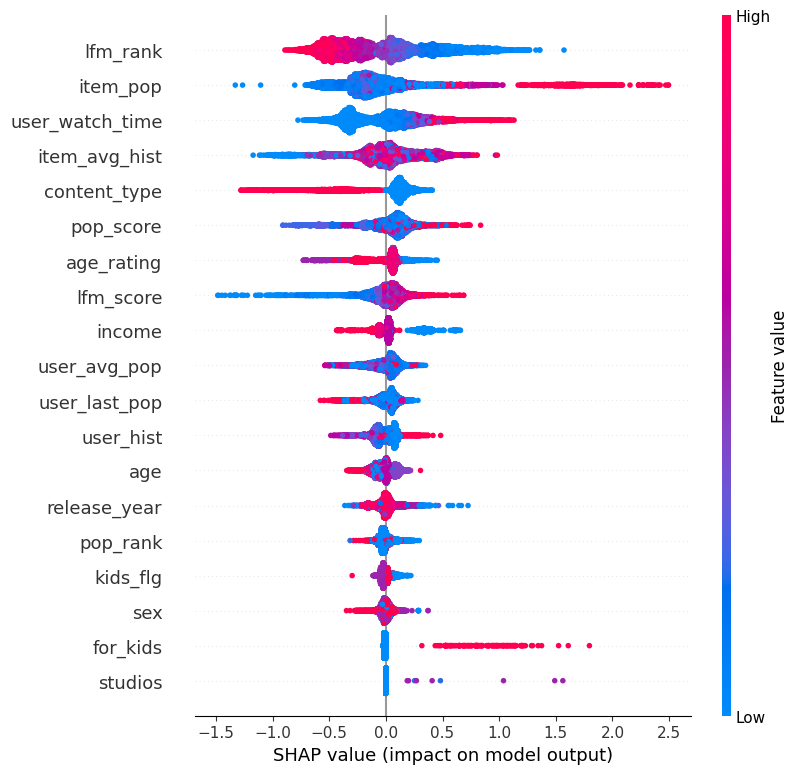

In [41]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

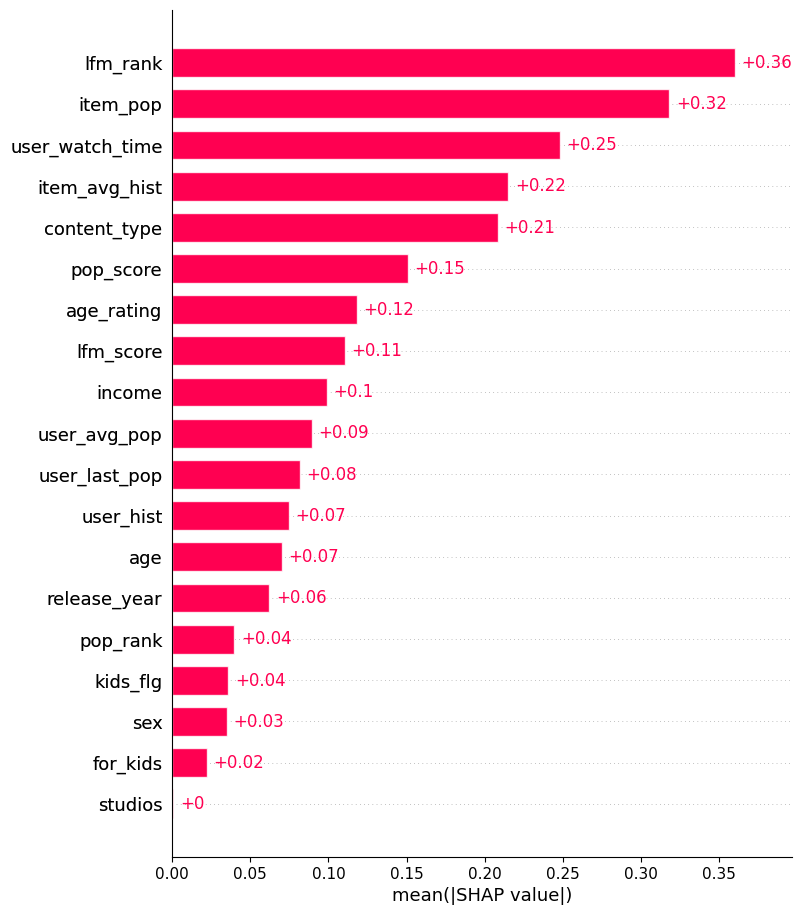

In [42]:
shap.plots.bar(shap_values, max_display=len(cols))

In [43]:
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test["target"])

y_pred

array([0.01229026, 0.00058356, 0.00122309, ..., 0.00159906, 0.00330654,
       0.08663292])

In [44]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f"{name}_score"] = y_pred_scores
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    mask = (df["lfm_rank"] < 101).to_numpy()

    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )

    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 101
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [45]:
ranker_test = add_score_and_rank(ranker_test, y_pred, "pointwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
28,53,9728,2021-07-01,0.0,0.0,3.248040,1,52.99,4088.0,3,...,-1,18.0,-1,76978.0,11.165736,0,0.104884,1,0.104884,1
10,53,3734,2021-07-30,11529.0,100.0,3.117941,2,50004.00,6.0,3,...,-1,16.0,-1,50004.0,12.134949,1,0.051460,2,0.051460,2
12,53,4151,2021-07-29,4302.0,13.0,2.971965,3,69641.00,4.0,3,...,-1,18.0,-1,69641.0,10.807886,0,0.024807,3,0.024807,3


In [46]:
roc_auc_score(y_true, y_pred)

0.8396903319147386

In [49]:
from typing import Callable, Dict, Set, List, Optional
def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["pointwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["pointwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.8341859258173661, 0.8341859258173661)

In [50]:
models_metrics["lfm"] = calc_metrics_(ranker_test, "lfm_rank")
models_metrics["pointwise"] = calc_metrics_(ranker_test, "pointwise_rank")
models_metrics["pointwise_hybrid"] = calc_metrics_(ranker_test, "pointwise_hybrid_rank")

pd.DataFrame(models_metrics)[["lfm", "pointwise", "pointwise_hybrid"]]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.026536,0.028005,0.028005
recall@10,0.085923,0.088779,0.088779
ndcg@10,0.033674,0.036326,0.036326
map@10,0.044013,0.048172,0.048172
novelty@10,3.303740,3.683119,3.683119


In [ ]:
# Listwise

In [51]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"])

In [52]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_watch_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,101,2021-07-01,0.0,0.0,1.764648,36,26.99,5295.0,-1,...,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0,0
1,3,142,2021-08-13,5892.0,100.0,2.385213,9,35862.00,8.0,-1,...,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1,2
2,3,849,2021-07-01,0.0,0.0,1.962757,25,13304.00,26.0,-1,...,0.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0,0


In [68]:
!pip install optuna

In [53]:
early_stopping_rounds = 32
params = {
    "objective": "lambdarank",  
    "n_estimators": 10000,  
    "max_depth": 4,  
    "num_leaves": 10,  
    "min_child_samples": 100,  
    "learning_rate": 0.25,  
    "reg_lambda": 1,  
    "colsample_bytree": 0.9,  
    "early_stopping_rounds": early_stopping_rounds,  
    "verbose": early_stopping_rounds // 8,  
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.924358
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.223499
[LightGBM] [Debug] init for col-wise cost 0.045014 seconds, init for row-wise cost 0.143584 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 6760250, number of used features: 19
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
Training u

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [54]:
listwise_model.best_score_["valid_0"]

OrderedDict([('ndcg@3', 0.717661155466863),
             ('ndcg@5', 0.7412726043338344),
             ('ndcg@10', 0.7636853345794623)])

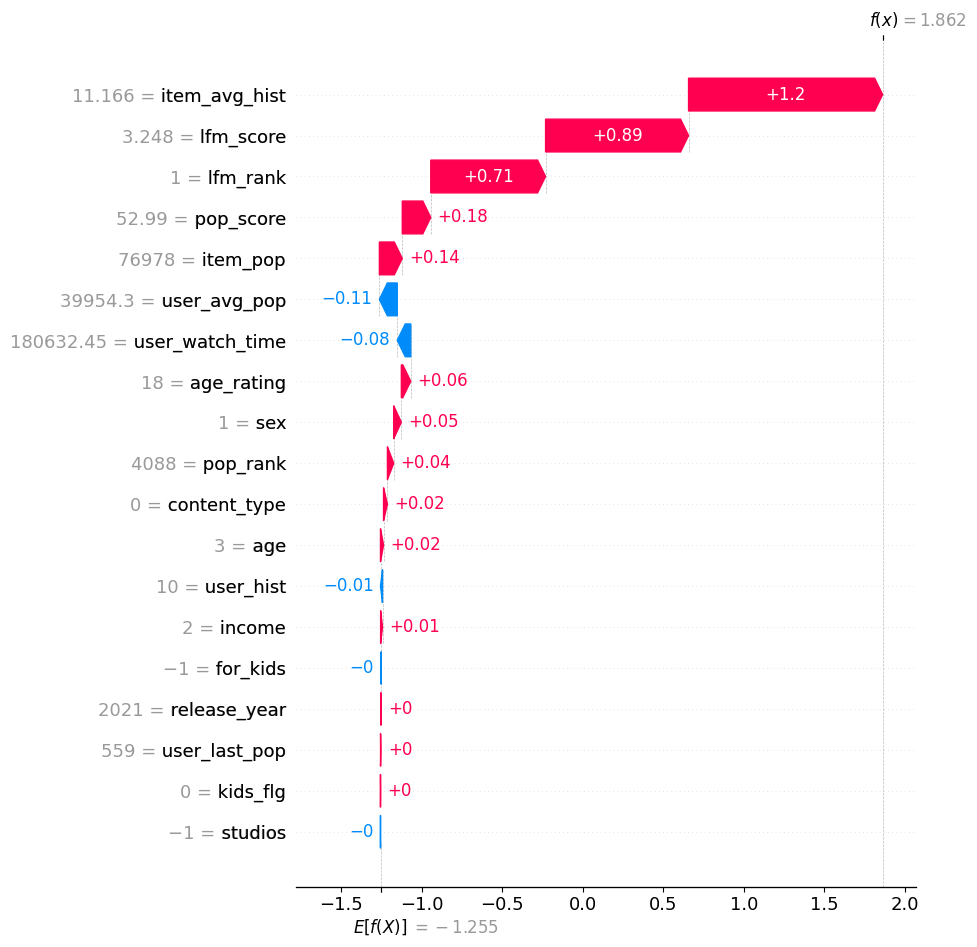

In [55]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

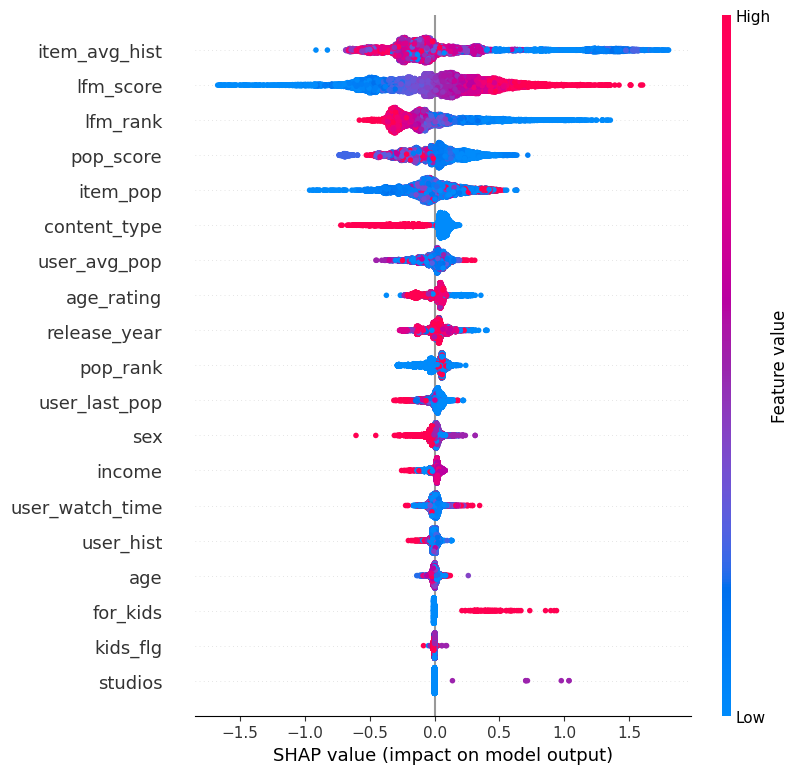

In [56]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

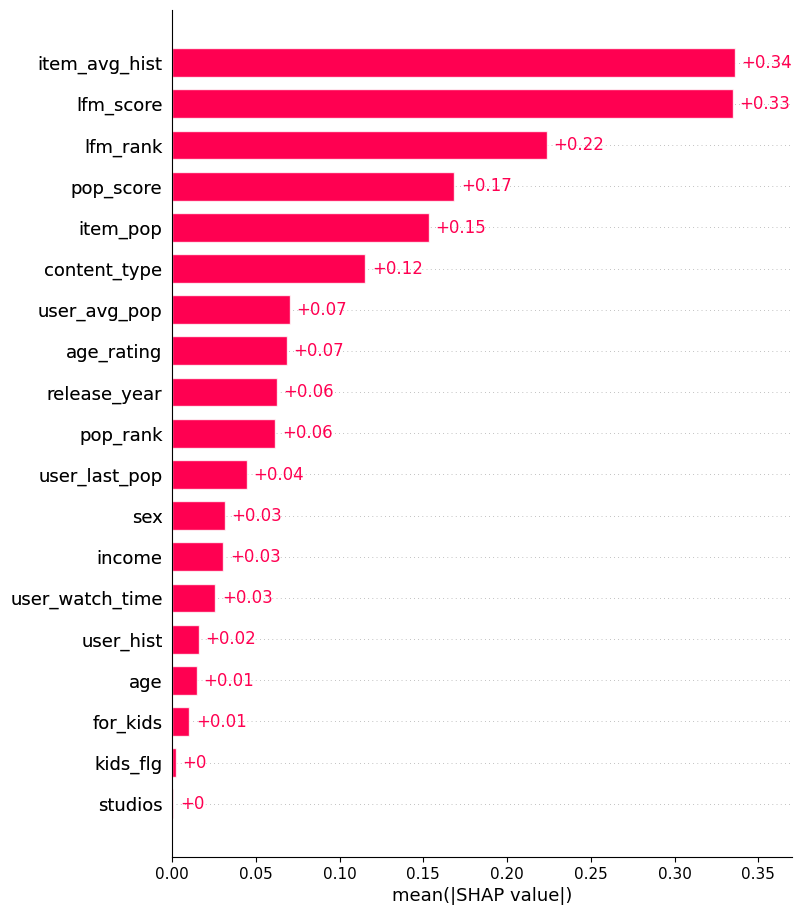

In [57]:
shap.plots.bar(shap_values, max_display=len(cols))

In [58]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
28,53,9728,2021-07-01,0.0,0.0,3.248040,1,52.99,4088.0,3,...,0,0.104884,1,0.104884,1,0,1.862226,1,1.862226,1
10,53,3734,2021-07-30,11529.0,100.0,3.117941,2,50004.00,6.0,3,...,1,0.051460,2,0.051460,2,2,1.325582,2,1.325582,2
12,53,4151,2021-07-29,4302.0,13.0,2.971965,3,69641.00,4.0,3,...,0,0.024807,3,0.024807,3,0,0.583678,3,0.583678,3


In [59]:
models_metrics["listwise"] = calc_metrics_(ranker_test, "listwise_rank")
models_metrics["listwise_hybrid"] = calc_metrics_(ranker_test, "listwise_hybrid_rank")
pd.DataFrame(models_metrics)[["listwise", "listwise_hybrid"]]

,listwise,listwise_hybrid
Precision@10,0.030171,0.030171
recall@10,0.097839,0.097839
ndcg@10,0.038631,0.038631
map@10,0.052047,0.052047
novelty@10,3.674132,3.674132


In [60]:
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["listwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["listwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.8320743911264178, 0.8320743911264178)

In [61]:
pd.DataFrame(models_metrics)[["lfm", "pointwise_hybrid", "listwise_hybrid"]]

,lfm,pointwise_hybrid,listwise_hybrid
Precision@10,0.026536,0.028005,0.030171
recall@10,0.085923,0.088779,0.097839
ndcg@10,0.033674,0.036326,0.038631
map@10,0.044013,0.048172,0.052047
novelty@10,3.303740,3.683119,3.674132


In [62]:
ranker_full = pd.concat([ranker_train, ranker_val, ranker_test])
len(ranker_full)

9652450

In [63]:
y_pred: np.ndarray = listwise_model.predict(ranker_full[cols])
ranker_full = add_score_and_rank(ranker_full, y_pred, "listwise")
ranker_full.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,target,target_ranker,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
47,3,15297,2021-07-01,0.0,0.0,2.997838,1,137128.00,2.0,-1,...,0,0,NaN,NaN,NaN,NaN,2.613928,1,2.613928,1
29,3,10440,2021-07-23,44827.0,90.0,2.989967,2,141889.00,1.0,-1,...,1,2,NaN,NaN,NaN,NaN,1.618544,2,1.618544,2
27,3,9728,2021-07-23,10448.0,100.0,2.709808,5,26.99,5295.0,-1,...,1,2,NaN,NaN,NaN,NaN,1.065836,3,1.065836,3
41,3,13865,2021-07-01,0.0,0.0,2.802499,3,93403.00,3.0,-1,...,0,0,NaN,NaN,NaN,NaN,0.791312,4,0.791312,4
10,3,4151,2021-07-24,17606.0,88.0,2.719305,4,69641.00,4.0,-1,...,1,2,NaN,NaN,NaN,NaN,0.391585,5,0.391585,5


In [64]:
K_RECS = 10
ranker_full = ranker_full[[Columns.User, Columns.Item, "listwise_hybrid_rank"]]
# Выбираем топ-10 рекомендаций
ranker_full = (
    ranker_full.sort_values([Columns.User, "listwise_hybrid_rank"])
    .groupby(Columns.User)
    .head(K_RECS)
)
ranker_full.drop("listwise_hybrid_rank", axis=1, inplace=True)
ranker_full.head()

,user_id,item_id
47,3,15297
29,3,10440
27,3,9728
41,3,13865
10,3,4151


In [65]:
recos_dict = ranker_full.groupby(Columns.User).agg(list).to_dict()[Columns.Item]

In [67]:
RECOS_PATH = "ranker_recos.json"
with open(RECOS_PATH, "w") as jf:
    json.dump(recos_dict, jf)